In [5]:
from sklearn.cluster import DBSCAN
from shapely.geometry import MultiPoint,Point,Polygon
import pandas as pd
import geopandas as gp
from shapely import wkt
import numpy as np
import matplotlib.pyplot as plt
from watertap3.truck_pipe_cost_functions import pipe_costing

from sklearn.cluster import DBSCAN
from shapely import wkt

1. Get location of brackish water wells
2. Assume an epsilon range and find the centroid
3. Calculate LCOW for cost of treatment +  transport cost (from well to centroid)
4. Plot LCOW as a function of epsilon

In [6]:
bw_df = pd.read_csv('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/Water Source Data/Brackish/brackish_sites_with_metrics_baseline_dwi_updated_costs_transport_updated_basis.csv')
texas = gp.read_file('/Users/mhardika/Documents/AMO/GeoToolAll_Methods/GeoData/Texas Counties Map/geo_export_c05b3355-1638-4e46-b56c-ac18de751ed8.shp')
texas = texas.to_crs("EPSG:4326")

In [7]:
bw_long = bw_df[bw_df['state_alpha']=='TX']['Longitude']
bw_lat = bw_df[bw_df['state_alpha']=='TX']['Latitude']

bw_geometry = [Point(xy) for xy in zip(bw_long,bw_lat)]
bw_geo_df = gp.GeoDataFrame(geometry = bw_geometry, crs='EPSG:4326')
bw_geo_df.geometry = bw_geo_df.geometry.to_crs('EPSG:4326')
bw_geo_df = bw_geo_df.assign(county_nm = bw_df[bw_df['state_alpha'] =='TX']['county_nm'].values)

In [8]:
coords = bw_df[bw_df['state_alpha']=='TX'][['Latitude', 'Longitude']].to_numpy()

In [9]:
# define the number of kilometers in one radian
kms_per_radian = 6371.0088
epsilon = 25/ kms_per_radian

db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

# get the number of clusters
num_clusters = len(set(cluster_labels))

# turn the clusters in to a pandas series, where each element is a cluster of points
clusters = pd.Series((coords[cluster_labels==n] for n in range(num_clusters)))
centroids = []

for ea in clusters:
    centroids.append((MultiPoint(ea).centroid.x, MultiPoint(ea).centroid.y))

centroids = np.array(centroids)

print(num_clusters)

64


In [10]:
loc = [Point(xy) for xy in zip(centroids[:,1],centroids[:,0])]
loc = gp.GeoDataFrame(geometry = loc, crs='EPSG:4326')
loc.geometry = loc.geometry.to_crs('EPSG:4326')

Add cluster labels to brackish water sites

In [11]:
bw_df_tx = bw_df[bw_df['state_alpha']=='TX']
bw_df_tx['cluster_label'] = cluster_labels

for x in range(len(bw_df_tx)):
    centroid_list = loc.geometry[bw_df_tx.iloc[x]['cluster_label']]

bw_df_tx['centroid'] = centroid_list

bw_df_tx.head()

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,lcow,pipe_cost,recovery,capital,onm,elec_int,tds_out,cluster_label,centroid
21,FETH-261730N0974730.1,TX,Cameron,26.291667,-97.791694,697.0,0.056956,4.06,Texas,0.0545,0.929783,0.064657,89.064718,14.228282,0.561861,3.400540,0.124022,0,POINT (-102.4776611 32.4681549)
22,FETH-262920N0974650.1,TX,Willacy,26.488889,-97.780583,1054.0,0.063528,2.32,Texas,0.0545,0.883958,0.056909,90.642666,15.015387,0.628462,3.487275,0.092029,0,POINT (-102.4776611 32.4681549)
24,FETH-291610N1003320.1,TX,Kinney,29.269444,-100.555583,1408.0,0.043813,2.61,Texas,0.0545,0.985774,0.073242,90.598937,11.540862,0.483226,3.978312,0.102851,1,POINT (-102.4776611 32.4681549)
25,FETH-292140N0950400.1,TX,Galveston,29.361111,-95.066694,884.0,0.113475,1.66,Texas,0.0545,0.769847,0.038590,91.107114,23.081943,1.008422,3.120036,0.072283,2,POINT (-102.4776611 32.4681549)
28,FETH-311340N0970030.1,TX,Falls,31.227778,-97.008361,2709.0,0.050385,1.68,Texas,0.0545,1.004942,0.064048,91.618259,12.529342,0.647890,5.228735,0.082720,3,POINT (-102.4776611 32.4681549)


In [12]:
# Checking for duplications
# dup = bw_df_tx[bw_df_tx.duplicated(['unique_site_ID'],keep = 'first' )]
# dup

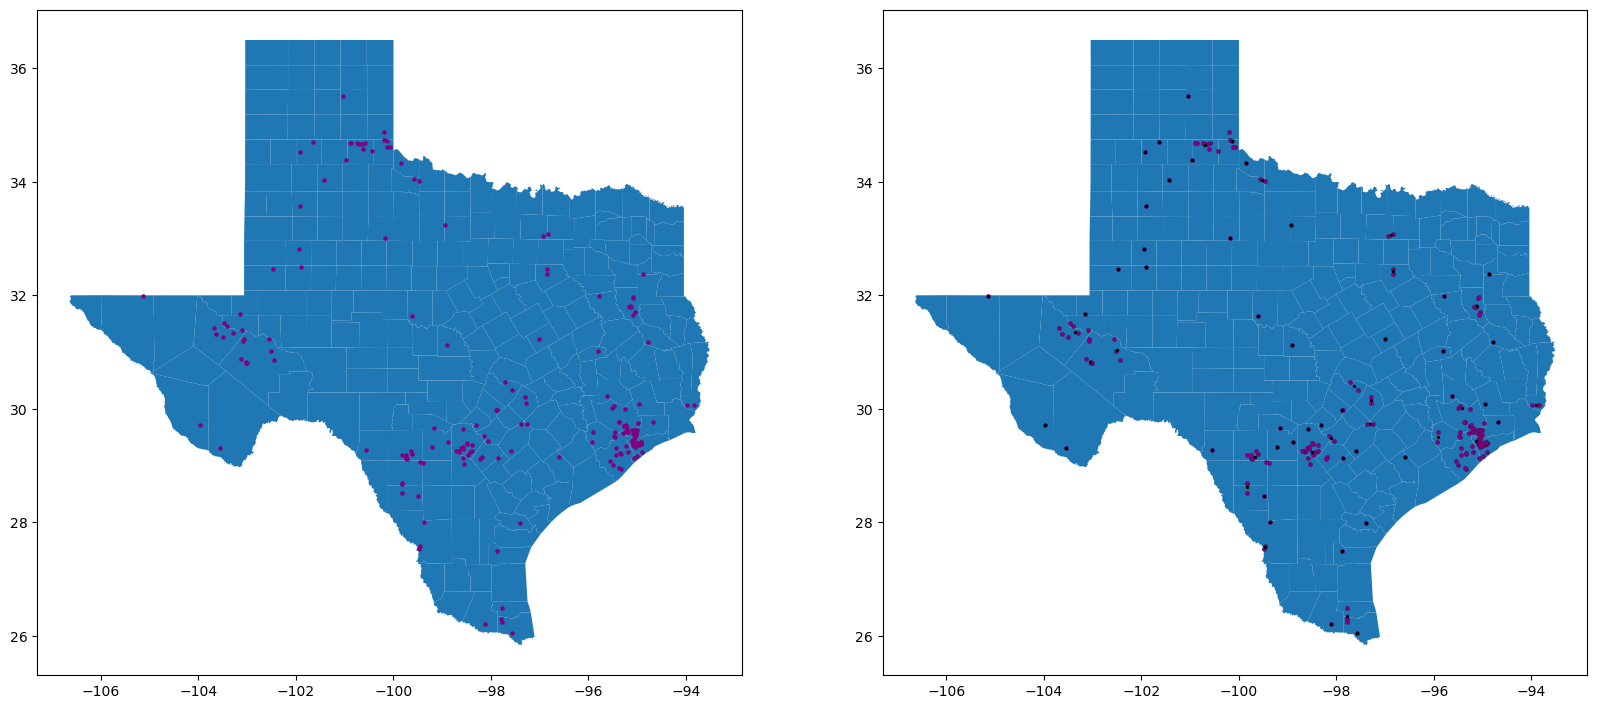

In [13]:
fig, (ax,ax0) = plt.subplots(1,2,figsize = (20,20))
# states[states['NAME'] == 'Texas'].plot(ax=ax,figsize=(20, 20))
texas.plot(ax=ax)
bw_geo_df.plot(ax=ax, color='purple', markersize = 5,label = "BW Sites")

texas.plot(ax=ax0)
bw_geo_df.plot(ax=ax0, markersize = 10,edgecolors = 'black', c='purple',linewidth = 0.1, label = "BW Sites")
ax0.scatter(centroids[:,1],centroids[:,0],color='black',s = 2)

In [30]:
bw_df.head()

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,lcow,pipe_cost,recovery,capital,onm,elec_int,tds_out
0,AZ_GEOTH-AZ0183,AZ,Pinal,32.639722,-111.945833,682.0,0.031545,0.754442,Arizona,0.0628,0.966084,0.085111,92.866138,8.879727,0.314866,2.663241,0.056599
1,AZ_GEOTH-AZ0274,AZ,Pinal,32.850556,-111.584444,374.0,0.070667,2.841712,Arizona,0.0628,0.862845,0.054834,89.781082,16.424565,0.657947,2.740707,0.100763
2,AZ_GEOTH-AZ0297,AZ,Pinal,32.894444,-111.558611,3265.0,0.125000,2.888000,Arizona,0.0628,0.993614,0.038441,89.849854,25.566372,1.856132,6.058783,0.103629
3,AZ_GEOTH-AZ0327,AZ,Pinal,32.931111,-111.550000,2566.0,0.037854,9.120000,Arizona,0.0628,1.305189,0.091942,86.213229,11.191279,0.615273,6.376542,0.210457
4,AZ_GEOTH-AZ0338,AZ,Pinal,32.936944,-111.566944,3000.0,0.063000,1.901000,Arizona,0.0628,1.037091,0.056027,91.183172,14.827503,0.914241,5.555922,0.088042


Brackish Water Supply Curve

In [29]:
bw_df_tx[bw_df_tx["cluster_label"]==0]

,unique_site_ID,state_alpha,county_nm,Latitude,Longitude,well_depth_ft,well_yield,TDS_kgm3,state,elec_price,lcow,pipe_cost,recovery,capital,onm,elec_int,tds_out,cluster_label,centroid
21,FETH-261730N0974730.1,TX,Cameron,26.291667,-97.791694,697.0,0.056956,4.06,Texas,0.0545,0.929783,0.064657,89.064718,14.228282,0.561861,3.400540,0.124022,0,POINT (-102.4776611 32.4681549)
22,FETH-262920N0974650.1,TX,Willacy,26.488889,-97.780583,1054.0,0.063528,2.32,Texas,0.0545,0.883958,0.056909,90.642666,15.015387,0.628462,3.487275,0.092029,0,POINT (-102.4776611 32.4681549)
523,TXWDB_BRAC-1737,TX,Cameron,26.249308,-97.781828,541.0,0.093121,3.16,Texas,0.0545,0.817909,0.046579,89.498061,20.338733,0.826614,3.027872,0.102705,0,POINT (-102.4776611 32.4681549)


Trying to create treatment train files

In [ ]:
cols = ['CaseStudy','Reference','Scenario','Unit','Type','UnitName','ToUnitName','FromPort','Parameter']

train_df = pd.DataFrame(columns= cols)

for